In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from tqdm.auto import tqdm
import os 

model_names = ['Llama3.2_1B', 'Llama3.1_8B',
                     'gemma-2-2b-it', 'gemma-2-9b-it',
                     'Phi-3.5-mini-instruct', 'Phi-3-medium-128k-instruct',
                     'OLMo-1B-hf', 'OLMo-7B-0724-Instruct-hf',
                     'Ministral-8B-Instruct-2410', 'Mistral-Nemo-Instruct-2407']
layers_counts = [16, 32, 
                 26, 42, 
                 32, 40,
                 16, 32,
                 36, 40]

model_name, layer_count = list(zip(model_names, layers_counts))[0]
layers = list(range(layer_count))

model_name += '_FirstWord'

os.makedirs(f'figs/{model_name}', exist_ok=True)

FONT_SIZE = 16


In [2]:
%load_ext autoreload
%autoreload 2
from plotters_utils import *

emotion_to_id, id_to_emotion, appraisals_to_id, id_to_appraisals, appraisal_to_formal_name, appraisal_to_formal_name_without_newline, appraisals, coefficients, biases, clean_logits, appraisal_labels = load_emotion_and_appraisals_list(model_name)
print(biases)


[ 2.46839031 -0.57551129 -0.12817462 -0.39858337 -0.14815189 -0.3912723
 -0.19717866 -0.13008168 -0.16035969  0.11939414 -0.20228227 -0.15624928
 -0.09993939]


In [3]:
save_prefix = ''
HOOK = True
if not HOOK:
    save_prefix = 'UNHOOKED_'

## Checking open vocab results

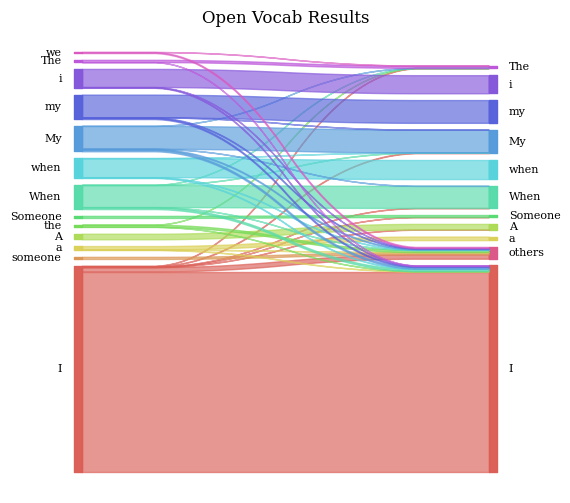

In [4]:
from copy import deepcopy

ground_truth, preds_model, filtered_preds = process_open_vocab(model_name, save_prefix, freq_threshold=10)

plot_sankey(ground_truth, filtered_preds, aspect = 10, fontsize=8, colorDict = None, save_path=f'{model_name}/open_vocab_results', title = 'Open Vocab Results')

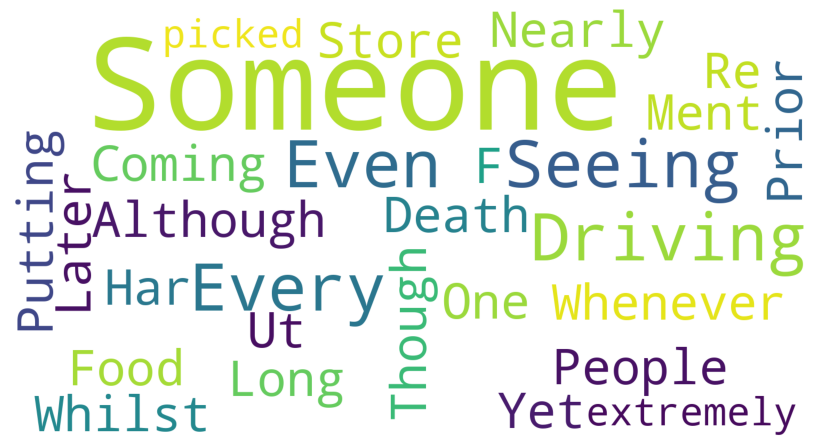

In [5]:
plot_wordcloud(list_of_words = preds_model, save_path = f'{model_name}/wordcloud', min_font_size=5)

## Comparing the filtered dataset

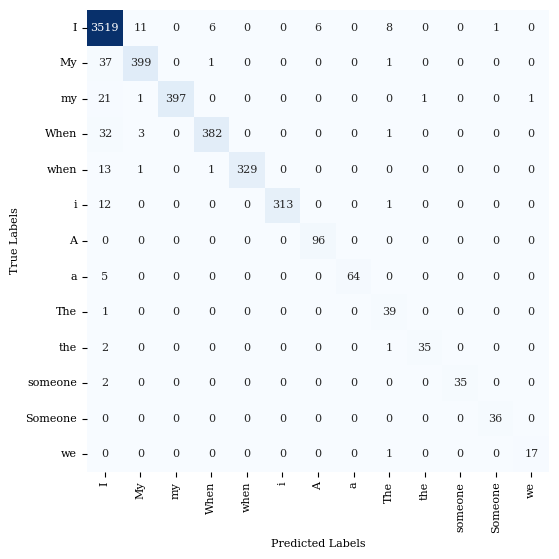

Accuracy: 0.970679012345679 Total: 5832 Correct: 5661


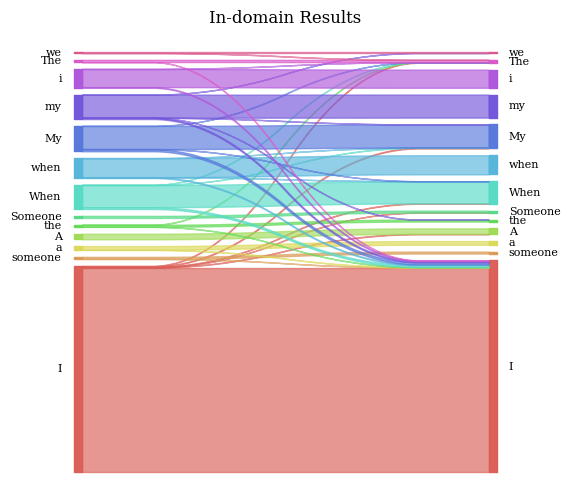

In [6]:
labels_predicted_, labels_true_ = torch.load(f'outputs/{model_name}/{save_prefix}unfiltered_emotion_logits.pt', weights_only=False)
plot_confusion_matrix(labels_true_, labels_predicted_, save_prefix=save_prefix, emotion_to_id=emotion_to_id, save_path=f'{model_name}/control_confusion_matrix', fontsize=8, figsize=(6,6))
labels_predicted = [id_to_emotion[label.item()] for label in labels_predicted_]
labels_true = [id_to_emotion[label.item()] for label in labels_true_]

plot_sankey(labels_true, labels_predicted, aspect = 10, fontsize=8, colorDict = None, save_path='', title = 'In-domain Results')


## Probing

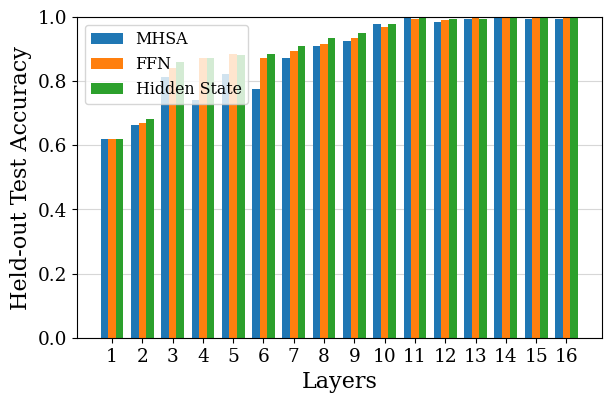

In [7]:
# emotion probe
locs_to_probe = [3, 6, 7]
tokens = [-1] #list(range(-1, -6, -1)) #
emotion_probe_results = process_emotion_probe_results(model_name, layers, locs_to_probe, tokens)
values = emotion_probe_results[:, tokens.index(-1)].unsqueeze(0)

plot_bars(values, figsize = (6, 4),
          labels = [f'{probe_location_to_formal_name[i]}' for i in locs_to_probe],
          xticklabels=[f'{i + 1}' for i in layers],
          bar_width = bar_width,
          fontsize = FONT_SIZE,
          titles=[''],
          suptitle='', 
          xlabel = 'Layers',
          ylabel= 'Held-out Test Accuracy',
          y_low = 0.0, y_high = 1.0,
          save_path=f'{model_name}/control_probe_last_token' #
          )

## Emotion Transfer using Patching

In [8]:
num_exps = 200
span = 3
tokens = [-1] # list(range(-1, -6, -1)) # 
locs_to_probe = [3, 6, 7]
layers_centers = list(range(span // 2, layer_count - span // 2))
activation_patching_results = process_activation_patching(model_name, num_exps, locs_to_probe, tokens, layers_centers, span)

  0%|          | 0/3 [00:00<?, ?it/s]

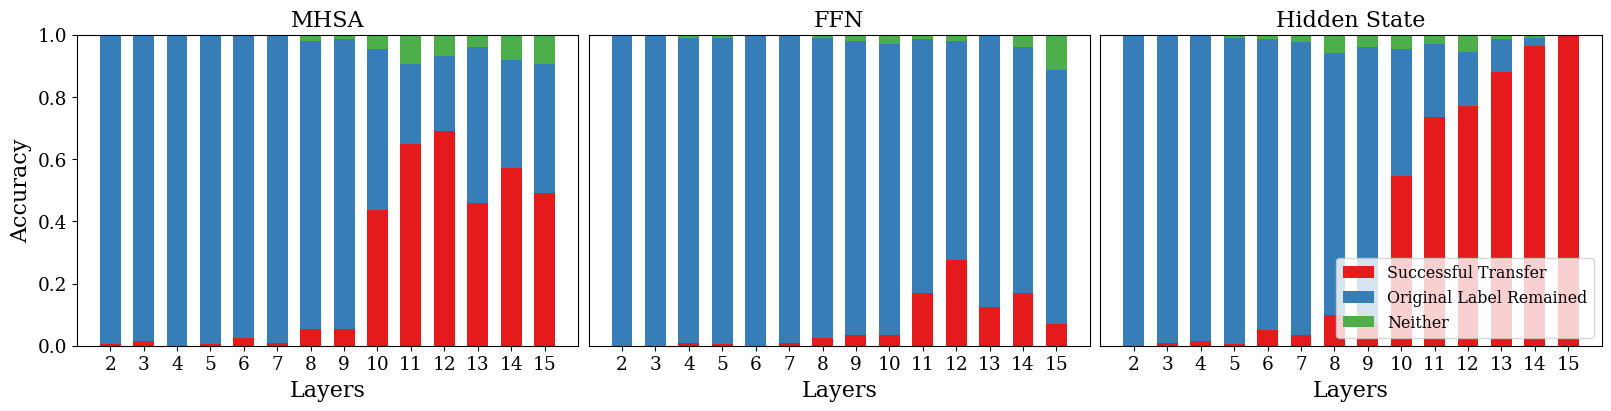

In [10]:
plot_cumulative_bar(activation_patching_results[:, tokens.index(-1)],
                    titles = [f'{probe_location_to_formal_name[l]}' for l in locs_to_probe],
                    bar_width = bar_width * 2.5, figsize = (16, 4), fontsize = FONT_SIZE,
                    xtick_labels_ = [np.array(layers_centers) + 1] * len(locs_to_probe),
                    x_low=1.0, x_high=16.0, y_low = 0.0, y_high = 1.0, colors = sns.color_palette("Set1"),
                    labels = ["Successful Transfer", "Original Label Remained", "Neither"], 
                    legend_loc = 'lower right', legend_index = 2,
                    save_path = f'{model_name}/control_activation_patching_{span}')
